### MLP on Streptococcus pneumoniae

In [1]:
import pandas as pd
import numpy as np
import random
import os
import json
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
import keras as keras
import tensorflow as tf
from keras import initializers
import scikeras
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedGroupKFold
from keras.optimizers.legacy import Adam
import seaborn as sns
from keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve, classification_report, average_precision_score
)
from scipy.stats import zscore


print("Tensorflow version:",tf.__version__)
print("Keras version:",keras.__version__)
print("Scikeras version:",scikeras.__version__)

Tensorflow version: 2.13.0
Keras version: 2.13.1
Scikeras version: 0.11.0


In [2]:
sp = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SP.csv')

/var/folders/mx/knhr23fd09g19g__8gz1fgxh0000gn/T/ipykernel_53032/1758425030.py:1: DtypeWarning: Columns (184337) have mixed types. Specify dtype option on import or set low_memory=False.
  sp = pd.read_csv('/Users/alexandra/Desktop/thesis_programming/final_SP.csv')


In [3]:
# Set a seed value
seed_value= 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [17]:
# Separate feature columns and target labels
X = sp.drop(columns=["CHL","TET","AZM","sample_ID"], errors='ignore')

X['ST'] = pd.to_numeric(X['ST'], errors='coerce')  
X = X.dropna(subset=['ST'])

# Create individual datasets per antibiotic
# Split into features and labels
sp_chl = X.copy()
sp_chl['label'] = sp['CHL']
y_chl = sp_chl['label']

sp_tet = X.copy()
sp_tet['label'] = sp['TET']
y_tet = sp_tet['label']

sp_azm = X.copy()
sp_azm['label'] = sp['AZM']
y_azm = sp_azm['label']

In [18]:
# Train-test split
X_train_chl, X_test_chl, y_train_chl, y_test_chl = train_test_split(
    X, y_chl, stratify=y_chl, test_size=0.3, random_state=42)

X_train_tet, X_test_tet, y_train_tet, y_test_tet = train_test_split(
    X, y_tet, stratify=y_tet, test_size=0.3, random_state=42)

X_train_azm, X_test_azm, y_train_azm, y_test_azm = train_test_split(
    X, y_azm, stratify=y_azm, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_chl, y_train_resampled_chl = smote.fit_resample(X_train_chl, y_train_chl)
X_train_resampled_azm, y_train_resampled_azm = smote.fit_resample(X_train_azm, y_train_azm)

print("CHL Resampled Class Distribution:", Counter(y_train_resampled_chl))
print("AZM Resampled Class Distribution:", Counter(y_train_resampled_azm))

CHL Resampled Class Distribution: Counter({0: 344, 1: 344})
AZM Resampled Class Distribution: Counter({0: 275, 1: 275})


In [19]:
# Prepare X and groups (drop ST from X, but use it for grouping)
groups_chl = X_train_resampled_chl['ST'].values
X_train_input_chl = X_train_resampled_chl.drop(columns=['ST'])
input_dim_chl = X_train_input_chl.shape[1]

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_tet = X_train_tet['ST'].values
X_train_input_tet = X_train_tet.drop(columns=['ST'])
input_dim_tet = X_train_input_tet.shape[1]

# Prepare X and groups (drop ST from X, but use it for grouping)
groups_azm = X_train_resampled_azm['ST'].values
X_train_input_azm = X_train_resampled_azm.drop(columns=['ST'])
input_dim_azm = X_train_input_azm.shape[1]

### Blocked cross-validation

In [7]:
# Define parameter grid 
param_grid = {
    'model__learning_rate': [0.001, 0.0001]
    #'model__dropout_rate': [0.5, 0.8]
}


In [8]:
# Define model-building function
def create_model(learning_rate=0.001, layer1_size=10, input_dim=input_dim_chl):
    model = Sequential()
    model.add(Dense(layer1_size, activation='sigmoid', input_shape=(input_dim,),kernel_initializer=initializers.HeNormal(seed=seed_value)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value)))
    model.compile(optimizer= Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  weighted_metrics=['accuracy'])
    return model

##### 1. CHL

In [47]:
import json
# Initialize the KerasClassifier
model_chl = KerasClassifier(model=create_model, 
                            epochs=100, 
                            verbose=0,
                            input_dim=input_dim_chl)

cv = StratifiedGroupKFold(n_splits=4)

# Perform Grid Search
grid = GridSearchCV(estimator=model_chl, param_grid=param_grid, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_chl, y_train_resampled_chl, groups=groups_chl, verbose=0)

# Get best parameters
params_chl = grid_result.best_params_

# Output the best results
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

2025-05-11 18:28:46.837027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:29:03.952097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:29:13.016217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:29:30.629898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:29:39.620902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:29:57.435880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:30:06.622606: I tensorflow/core/grappler/optimizers/cust

Best Accuracy: 0.6607
Best Parameters: {'model__learning_rate': 0.0001}


##### 2. TET

In [45]:
model_tet = KerasClassifier(model=create_model, 
                        epochs=100, 
                        verbose=0,
                        input_dim=input_dim_tet)


cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_tet, param_grid=param_grid, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_tet, y_train_tet, groups=groups_tet, verbose=0)
params_tet = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

2025-05-11 18:23:03.889481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:23:14.103788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:23:15.520242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:23:24.931169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:23:26.237013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:23:35.177759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:23:36.524411: I tensorflow/core/grappler/optimizers/cust

Best Accuracy: 0.6796
Best Parameters: {'model__learning_rate': 0.0001}


##### 3. AZM

In [46]:
model_azm = KerasClassifier(model=create_model, 
                        epochs=100, 
                        verbose=0,
                        input_dim=input_dim_azm)


cv = StratifiedGroupKFold(n_splits=4)
# Grid search
grid = GridSearchCV(estimator=model_azm, param_grid=param_grid, cv=cv, refit='f1_macro', return_train_score=True, scoring='f1_macro')
grid_result = grid.fit(X_train_input_azm, y_train_resampled_azm, groups=groups_azm, verbose=0)
params_azm = grid_result.best_params_

# Output
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Parameters: {grid_result.best_params_}")

2025-05-11 18:25:15.469702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:25:32.012034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:25:37.920161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:25:52.547999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:26:00.877134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:26:14.499999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-05-11 18:26:22.914156: I tensorflow/core/grappler/optimizers/cust

Best Accuracy: 0.8266
Best Parameters: {'model__learning_rate': 0.0001}


### Training with best hyperparameters and testing

In [ ]:
def train_mlp_model(X_train, y_train, params):

    model = create_model(
        learning_rate= params['model__learning_rate'],
        # dropout_rate=params['model__dropout_rate'],
        # layer1_size=params['model__layer1_size'],
        # layer2_size=params['model__layer2_size'],
        input_dim=X_train.shape[1]
    )

    # Early stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=100,
        batch_size=64,
        callbacks=[early_stop],
        verbose=1,
        shuffle=False,

    )
    

    return model, history


In [21]:
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold=0.5, model_name=None):
    """
    Evaluates a binary classification model, compares training vs test accuracy,
    includes per-class metrics, and plots ROC and Precision-Recall curves.

    Parameters:
        model: Trained model 
        X_train, y_train: Training data (for overfitting check)
        X_test, y_test: Test data (for evaluation)
        threshold: Threshold for class prediction

    """
    # Predict probabilities
    y_test_prob = model.predict(X_test)
    y_train_prob = model.predict(X_train)

    # Flatten if needed (Keras outputs)
    if y_test_prob.ndim > 1:
        y_test_prob = y_test_prob.ravel()
    if y_train_prob.ndim > 1:
        y_train_prob = y_train_prob.ravel()

    # Apply threshold
    y_test_pred = (y_test_prob >= threshold).astype(int)
    y_train_pred = (y_train_prob >= threshold).astype(int)

    # Core metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    prec = precision_score(y_test, y_test_pred, zero_division=0)
    rec = recall_score(y_test, y_test_pred, zero_division=0)
    f1 = f1_score(y_test, y_test_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_test_pred)
    roc_auc = auc(*roc_curve(y_test, y_test_prob)[:2])

    # Classification report (per class)
    report = classification_report(y_test, y_test_pred, target_names=["Susceptible", "Resistant"], output_dict=True)

    # Display confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix for MLP Model of {}".format(model_name))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for MLP Model of {}'.format(model_name))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute precision-recall values
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

    # Compute PR AUC (Average Precision)
    pr_auc = average_precision_score(y_test, y_test_prob)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for MLP Model of {}'.format(model_name))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:     {test_acc:.4f}")
    print(f"Overall Precision: {prec:.4f}")
    print(f"Overall Recall:    {rec:.4f}")
    print(f"Overall F1 Score:  {f1:.4f}")
    print(f"ROC AUC:           {roc_auc:.4f}")

    print("\nPer-Class Performance:")
    for cls in ["Susceptible", "Resistant"]:
        cls_metrics = report[cls]
        print(f"{cls:12} | Precision: {cls_metrics['precision']:.2f} | Recall: {cls_metrics['recall']:.2f} | F1: {cls_metrics['f1-score']:.2f}")
    
    print(report)


In [22]:
# Separate feature columns and target labels
X = sp.drop(columns=['CHL',"TET","AZM","sample_ID", 'ST'], errors='ignore')

# Create individual datasets per antibiotic
# Split into features and labels
sp_chl = X.copy()
sp_chl['label'] = sp['CHL']
y_chl = sp_chl['label']

sp_tet = X.copy()
sp_tet['label'] = sp['TET']
y_tet = sp_tet['label']

sp_azm = X.copy()
sp_azm['label'] = sp['AZM']
y_azm = sp_azm['label']


# Train-test split
X_train_chl, X_test_chl, y_train_chl, y_test_chl = train_test_split(
    X, y_chl, stratify=y_chl, test_size=0.3, random_state=42)

X_train_tet, X_test_tet, y_train_tet, y_test_tet = train_test_split(
    X, y_tet, stratify=y_tet, test_size=0.3, random_state=42)

X_train_azm, X_test_azm, y_train_azm, y_test_azm = train_test_split(
    X, y_azm, stratify=y_azm, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled_chl, y_train_resampled_chl = smote.fit_resample(X_train_chl, y_train_chl)
X_train_resampled_azm, y_train_resampled_azm = smote.fit_resample(X_train_azm, y_train_azm)

print("CHL Resampled Class Distribution:", Counter(y_train_resampled_chl))
print("TET Class Distribution:", Counter(y_train_tet))
print("AZM Resampled Class Distribution:", Counter(y_train_resampled_azm))

# X_train_resampled_* for training (70%)
# X_test_* for testing (30%)

CHL Resampled Class Distribution: Counter({0: 379, 1: 379})
TET Class Distribution: Counter({0: 232, 1: 185})
AZM Resampled Class Distribution: Counter({1: 295, 0: 295})


##### 1. CHL

In [ ]:
X_train_resampled_chl.shape

(758, 184333)

2025-05-13 08:41:59.149754: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-13 08:41:59.149822: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-05-13 08:41:59.149841: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-05-13 08:41:59.150297: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-13 08:41:59.150723: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100


2025-05-13 08:42:00.877689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 94ms/step - loss: 0.9015 - accuracy: 0.6349 - val_loss: 0.4918 - val_accuracy: 0.9211
Epoch 2/100
 4/11 [=========>....................] - ETA: 0s - loss: 0.7362 - accuracy: 0.4102

2025-05-13 08:42:02.073623: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 0s 22ms/step - loss: 0.6305 - accuracy: 0.6437 - val_loss: 0.4918 - val_accuracy: 0.9868
Epoch 3/100
11/11 [==============================] - 0s 18ms/step - loss: 0.4252 - accuracy: 0.9179 - val_loss: 0.4400 - val_accuracy: 0.9605
Epoch 4/100
11/11 [==============================] - 0s 17ms/step - loss: 0.3207 - accuracy: 0.9472 - val_loss: 0.3826 - val_accuracy: 1.0000
Epoch 5/100
11/11 [==============================] - 0s 18ms/step - loss: 0.3033 - accuracy: 0.9751 - val_loss: 0.3635 - val_accuracy: 1.0000
Epoch 6/100
11/11 [==============================] - 0s 17ms/step - loss: 0.2896 - accuracy: 0.9765 - val_loss: 0.3638 - val_accuracy: 1.0000
Epoch 7/100
11/11 [==============================] - 0s 18ms/step - loss: 0.2789 - accuracy: 0.9780 - val_loss: 0.3584 - val_accuracy: 1.0000
Epoch 8/100
11/11 [==============================] - 0s 17ms/step - loss: 0.2698 - accuracy: 0.9853 - val_loss: 0.3546 - val_accuracy: 1.0000
Epoch 9/100
11/11 

2025-05-13 08:42:21.689168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 0s 6ms/step


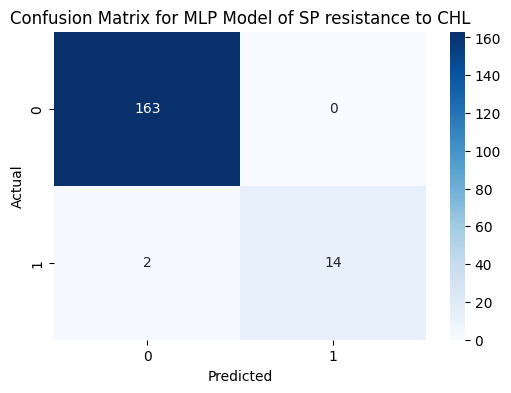

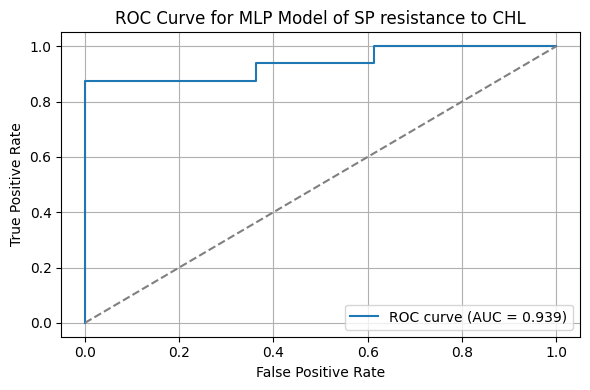

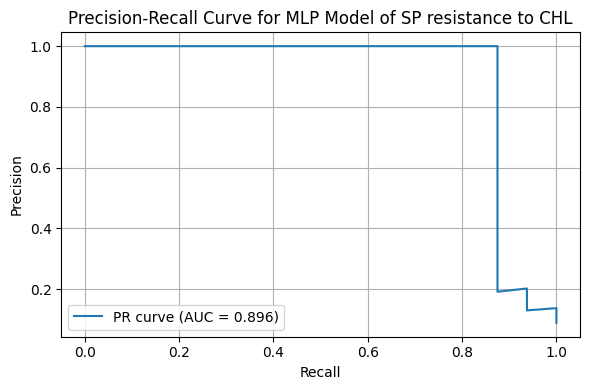

Training Accuracy: 1.0000
Test Accuracy:     0.9888
Overall Precision: 1.0000
Overall Recall:    0.8750
Overall F1 Score:  0.9333
ROC AUC:           0.9390

Per-Class Performance:
Susceptible  | Precision: 0.99 | Recall: 1.00 | F1: 0.99
Resistant    | Precision: 1.00 | Recall: 0.88 | F1: 0.93
{'Susceptible': {'precision': 0.9878787878787879, 'recall': 1.0, 'f1-score': 0.9939024390243903, 'support': 163.0}, 'Resistant': {'precision': 1.0, 'recall': 0.875, 'f1-score': 0.9333333333333333, 'support': 16.0}, 'accuracy': 0.9888268156424581, 'macro avg': {'precision': 0.9939393939393939, 'recall': 0.9375, 'f1-score': 0.9636178861788618, 'support': 179.0}, 'weighted avg': {'precision': 0.9889622481801253, 'recall': 0.9888268156424581, 'f1-score': 0.9884884407503295, 'support': 179.0}}


In [ ]:
mlp_chl, _ = train_mlp_model(X_train_resampled_chl, y_train_resampled_chl, params_chl)
evaluate_model(mlp_chl, X_train_resampled_chl, y_train_resampled_chl, X_test_chl, y_test_chl, threshold=0.5, model_name="SP resistance to CHL")

##### 2. TET

In [ ]:
X_train_tet.shape

(417, 184333)

Epoch 1/100


2025-05-13 08:44:35.625324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 55ms/step - loss: 0.6343 - accuracy: 0.6453 - val_loss: 0.5535 - val_accuracy: 0.7381
Epoch 2/100
6/6 [==============================] - 0s 18ms/step - loss: 0.4692 - accuracy: 0.8213 - val_loss: 0.4669 - val_accuracy: 0.8095
Epoch 3/100


2025-05-13 08:44:36.063076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 19ms/step - loss: 0.3961 - accuracy: 0.8613 - val_loss: 0.3983 - val_accuracy: 0.7857
Epoch 4/100
6/6 [==============================] - 0s 18ms/step - loss: 0.3283 - accuracy: 0.9200 - val_loss: 0.3327 - val_accuracy: 0.9286
Epoch 5/100
6/6 [==============================] - 0s 17ms/step - loss: 0.3060 - accuracy: 0.9467 - val_loss: 0.3236 - val_accuracy: 0.8333
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.2790 - accuracy: 0.9360 - val_loss: 0.2903 - val_accuracy: 0.9286
Epoch 7/100
6/6 [==============================] - 0s 18ms/step - loss: 0.2622 - accuracy: 0.9867 - val_loss: 0.2896 - val_accuracy: 0.9048
Epoch 8/100
6/6 [==============================] - 0s 18ms/step - loss: 0.2496 - accuracy: 0.9680 - val_loss: 0.2808 - val_accuracy: 0.9048
Epoch 9/100
6/6 [==============================] - 0s 18ms/step - loss: 0.2391 - accuracy: 0.9867 - val_loss: 0.2741 - val_accuracy: 0.9286
Epoch 10/100
6/6 [==============

2025-05-13 08:44:47.752871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 17ms/step


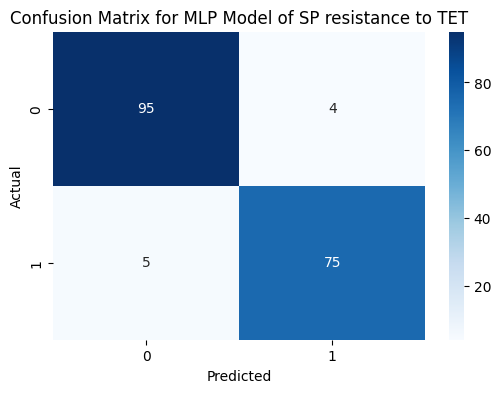

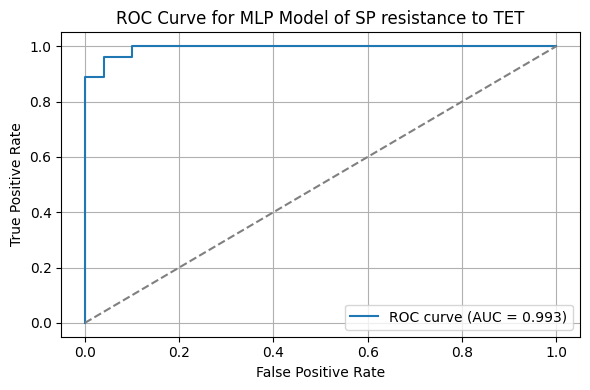

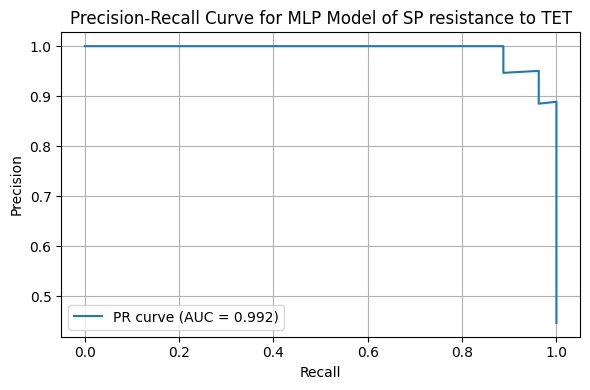

Training Accuracy: 0.9952
Test Accuracy:     0.9497
Overall Precision: 0.9494
Overall Recall:    0.9375
Overall F1 Score:  0.9434
ROC AUC:           0.9932

Per-Class Performance:
Susceptible  | Precision: 0.95 | Recall: 0.96 | F1: 0.95
Resistant    | Precision: 0.95 | Recall: 0.94 | F1: 0.94
{'Susceptible': {'precision': 0.95, 'recall': 0.9595959595959596, 'f1-score': 0.9547738693467336, 'support': 99.0}, 'Resistant': {'precision': 0.9493670886075949, 'recall': 0.9375, 'f1-score': 0.9433962264150944, 'support': 80.0}, 'accuracy': 0.9497206703910615, 'macro avg': {'precision': 0.9496835443037974, 'recall': 0.9485479797979798, 'f1-score': 0.949085047880914, 'support': 179.0}, 'weighted avg': {'precision': 0.9497171345732267, 'recall': 0.9497206703910615, 'f1-score': 0.9496888892655542, 'support': 179.0}}


In [ ]:
# fara smote
mlp_tet, _ = train_mlp_model(X_train_tet, y_train_tet, params_tet)
evaluate_model(mlp_tet, X_train_tet, y_train_tet, X_test_tet, y_test_tet, threshold=0.4, model_name="SP resistance to TET")

##### 3. AZM

In [29]:
X_train_resampled_azm.shape

(590, 184333)

Epoch 1/100


2025-05-13 08:44:59.615424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 1s 88ms/step - loss: 0.5543 - accuracy: 0.7589 - val_loss: 0.3938 - val_accuracy: 0.9831
Epoch 2/100
4/9 [============>.................] - ETA: 0s - loss: 0.6809 - accuracy: 0.4727

2025-05-13 08:45:00.435256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 0s 20ms/step - loss: 0.5876 - accuracy: 0.6215 - val_loss: 0.6573 - val_accuracy: 0.7458
Epoch 3/100
9/9 [==============================] - 0s 19ms/step - loss: 0.3277 - accuracy: 0.9077 - val_loss: 0.4078 - val_accuracy: 0.9661
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 0.3242 - accuracy: 0.8927 - val_loss: 0.4351 - val_accuracy: 0.9492
Epoch 5/100
9/9 [==============================] - 0s 19ms/step - loss: 0.2861 - accuracy: 0.9303 - val_loss: 0.4201 - val_accuracy: 0.9492
Epoch 6/100
9/9 [==============================] - 0s 19ms/step - loss: 0.2677 - accuracy: 0.9623 - val_loss: 0.4147 - val_accuracy: 0.9661
Epoch 7/100
9/9 [==============================] - 0s 18ms/step - loss: 0.2527 - accuracy: 0.9605 - val_loss: 0.4117 - val_accuracy: 0.9661
Epoch 8/100
9/9 [==============================] - 0s 19ms/step - loss: 0.2435 - accuracy: 0.9793 - val_loss: 0.4051 - val_accuracy: 0.9831
Epoch 9/100
9/9 [===============

2025-05-13 08:45:16.556665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 8ms/step


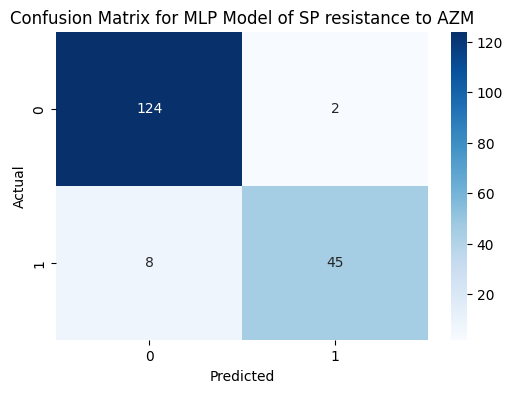

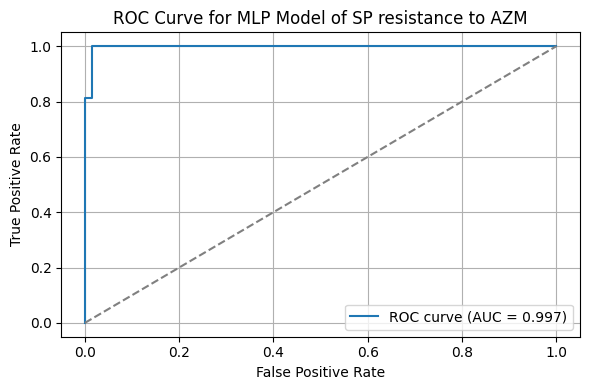

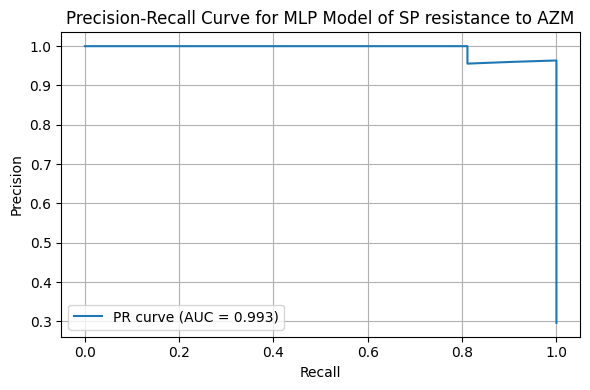

Training Accuracy: 1.0000
Test Accuracy:     0.9441
Overall Precision: 0.9574
Overall Recall:    0.8491
Overall F1 Score:  0.9000
ROC AUC:           0.9970

Per-Class Performance:
Susceptible  | Precision: 0.94 | Recall: 0.98 | F1: 0.96
Resistant    | Precision: 0.96 | Recall: 0.85 | F1: 0.90
{'Susceptible': {'precision': 0.9393939393939394, 'recall': 0.9841269841269841, 'f1-score': 0.9612403100775193, 'support': 126.0}, 'Resistant': {'precision': 0.9574468085106383, 'recall': 0.8490566037735849, 'f1-score': 0.9, 'support': 53.0}, 'accuracy': 0.9441340782122905, 'macro avg': {'precision': 0.948420373952289, 'recall': 0.9165917939502846, 'f1-score': 0.9306201550387596, 'support': 179.0}, 'weighted avg': {'precision': 0.9447392023167609, 'recall': 0.9441340782122905, 'f1-score': 0.9431077043003767, 'support': 179.0}}


In [ ]:
mlp_azm, _ = train_mlp_model(X_train_resampled_azm, y_train_resampled_azm, params_azm)
evaluate_model(mlp_azm, X_train_resampled_azm, y_train_resampled_azm, X_test_azm, y_test_azm, threshold=0.5, model_name="SP resistance to AZM")

### Feature importance

In [14]:
def get_top_outliers(model, X_train):
    #keras_model = mlp_chl.model()
    weights = [layer.get_weights()[0] for layer in model.layers if isinstance(layer, keras.layers.Dense)]


    # Flatten the weights into a single vector
    flattened_weights = np.concatenate([w.flatten() for w in weights])

    # Compute Z-scores for the flattened weights
    z_scores = zscore(flattened_weights)

    # Identify outliers (e.g., Z-score > 3 or Z-score < -3 are considered outliers)
    outliers = np.where(np.abs(z_scores) > 3)[0]  # Indices of outliers
    print("Outlier indices based on Z-scores:", outliers)

    # Get the absolute values of the outlier weights
    outlier_weights = np.abs(flattened_weights[outliers])

    # Rank the outliers based on their absolute weight values (highest first)
    top_20_outlier_indices = outliers[np.argsort(outlier_weights)[-20:][::-1]]

    print("Top 20 outlier indices:", top_20_outlier_indices)

    # For the first layer, map outlier indices to input features
    first_layer_weights = weights[0]  # The weights of the first layer

    # Map the top 20 outlier indices to input feature indices
    input_feature_indices = top_20_outlier_indices % first_layer_weights.shape[0]

    print("Top 20 outlier features (input feature indices):", input_feature_indices)

    # Display the top 20 outlier features and their corresponding weights
    top_20_outlier_weights = flattened_weights[top_20_outlier_indices]
    print("Top 20 Outlier Features and Their Corresponding Weights:")
    for i, idx in enumerate(top_20_outlier_indices):
        print(f"Feature {input_feature_indices[i]}: Weight = {top_20_outlier_weights[i]}")


    # Get the column names (feature names)
    feature_names = X_train.columns

    # Map the top 20 outlier indices to the corresponding feature names
    top_20_feature_names = feature_names[input_feature_indices]  # input_feature_indices is from previous steps

    print("Top 20 outlier feature names:", top_20_feature_names)

    return top_20_feature_names, top_20_outlier_weights




In [15]:
def visualize_outliers(top_20_feature_names, top_20_outlier_weights, drug_name):

    # Set figure size for better readability
    plt.figure(figsize=(14, 7))

    # Separate positive and negative weights
    positive_weights = top_20_outlier_weights[top_20_outlier_weights > 0]
    negative_weights = top_20_outlier_weights[top_20_outlier_weights < 0]

    # Define color maps for positive (red) and negative (blue) weights
    positive_colors = plt.cm.Reds(np.linspace(0, 1, len(positive_weights)))  # Reds for positive weights
    negative_colors = plt.cm.Blues(np.linspace(0, 1, len(negative_weights)))  # Blues for negative weights

    # Plot bars for positive and negative weights
    bars_positive = plt.barh(range(len(positive_weights)), positive_weights, color=positive_colors)
    bars_negative = plt.barh(range(len(positive_weights), len(positive_weights) + len(negative_weights)), 
                            negative_weights, color=negative_colors)

    # Add feature names as y-ticks for both positive and negative bars
    plt.yticks(range(len(top_20_feature_names)), top_20_feature_names, fontsize=10)

    # Add titles and labels with a larger font size
    plt.title('Top 20 Outlier Features\n(MLP - SP Resistance to {})'.format(drug_name))
    plt.xlabel('Outlier Weight Value', fontsize=12)
    plt.ylabel('Feature Name', fontsize=12)

    # Optionally, add gridlines to make it easier to read the x-values
    plt.grid(axis='x', linestyle='--', alpha=0.7)


    # Adjust layout to ensure everything fits properly
    plt.tight_layout()

    # Show the plot
    plt.show()


##### 1. CHL

Outlier indices based on Z-scores: [  18731   19121   19331 ... 1843337 1843338 1843339]
Top 20 outlier indices: [1843333 1843339 1843334 1843338 1843337 1843336 1843332 1843330 1843335
 1522247 1522497 1522077  272567 1522307 1522437 1643367 1643287  883317
  123316 1719107]
Top 20 outlier features (input feature indices): [     3      9      4      8      7      6      2      0      5  47583
  47833  47413  88234  47643  47773 168703 168623 145985 123316  60110]
Top 20 Outlier Features and Their Corresponding Weights:
Feature 3: Weight = -0.7435374855995178
Feature 9: Weight = -0.694013774394989
Feature 4: Weight = -0.6631735563278198
Feature 8: Weight = -0.5778551697731018
Feature 7: Weight = -0.5180150270462036
Feature 6: Weight = 0.43764013051986694
Feature 2: Weight = 0.380328506231308
Feature 0: Weight = -0.36266279220581055
Feature 5: Weight = 0.2620227336883545
Feature 47583: Weight = 0.051719725131988525
Feature 47833: Weight = 0.05171867087483406
Feature 47413: Weight = 0.05

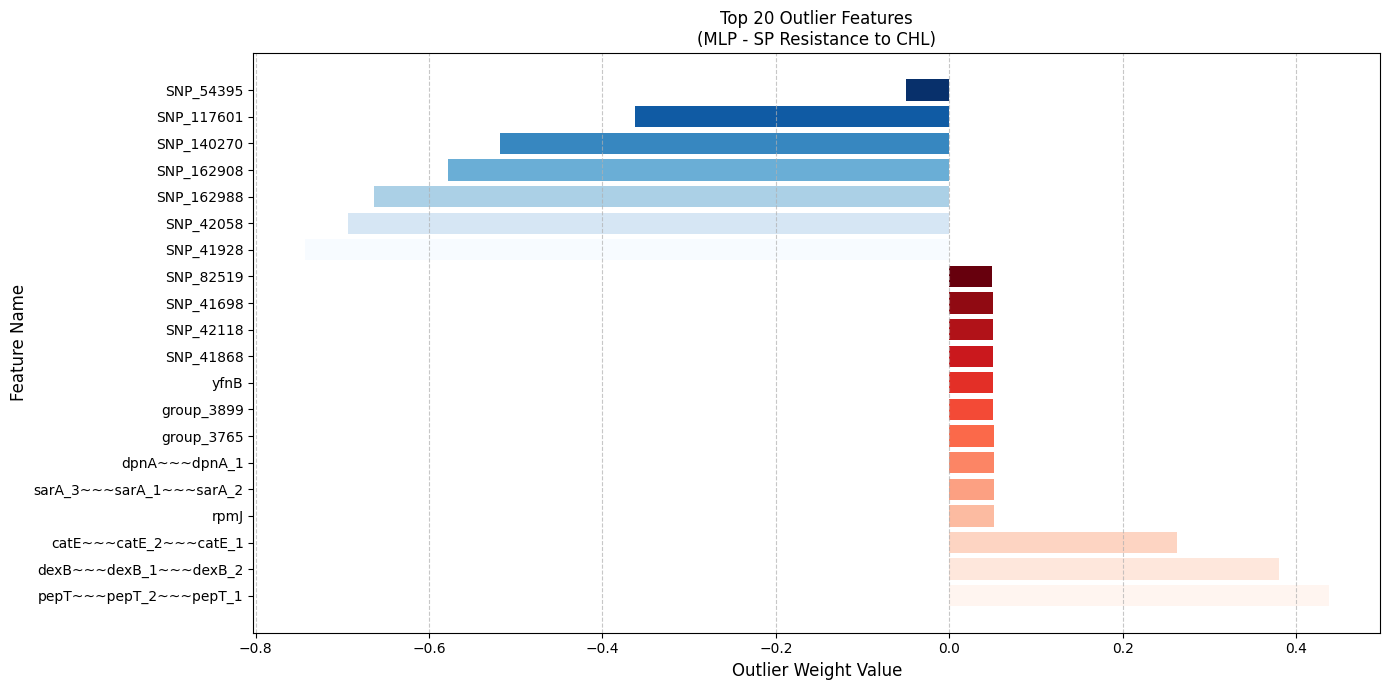

In [16]:
feature_names_chl, outlier_weights_chl = get_top_outliers(mlp_chl, X_train_resampled_chl)
visualize_outliers(feature_names_chl, outlier_weights_chl, drug_name="CHL")

##### 2. TET

Outlier indices based on Z-scores: [  17351   17741   18331 ... 1843337 1843338 1843339]
Top 20 outlier indices: [1843333 1843339 1843334 1843338 1843337 1843336 1843332 1843330 1843335
 1843331   22211 1538171 1679911  762171   26291 1783691  911571 1538251
   26771   22851]
Top 20 outlier features (input feature indices): [     3      9      4      8      7      6      2      0      5      1
  22211  63507  20914  24839  26291 124694 174239  63587  26771  22851]
Top 20 Outlier Features and Their Corresponding Weights:
Feature 3: Weight = -0.756308913230896
Feature 9: Weight = -0.704422116279602
Feature 4: Weight = -0.668979287147522
Feature 8: Weight = -0.5942327976226807
Feature 7: Weight = -0.5288912653923035
Feature 6: Weight = 0.434464693069458
Feature 2: Weight = 0.3764008581638336
Feature 0: Weight = -0.36723965406417847
Feature 5: Weight = 0.24495726823806763
Feature 1: Weight = -0.05184371769428253
Feature 22211: Weight = -0.03633500635623932
Feature 63507: Weight = 0.0345858

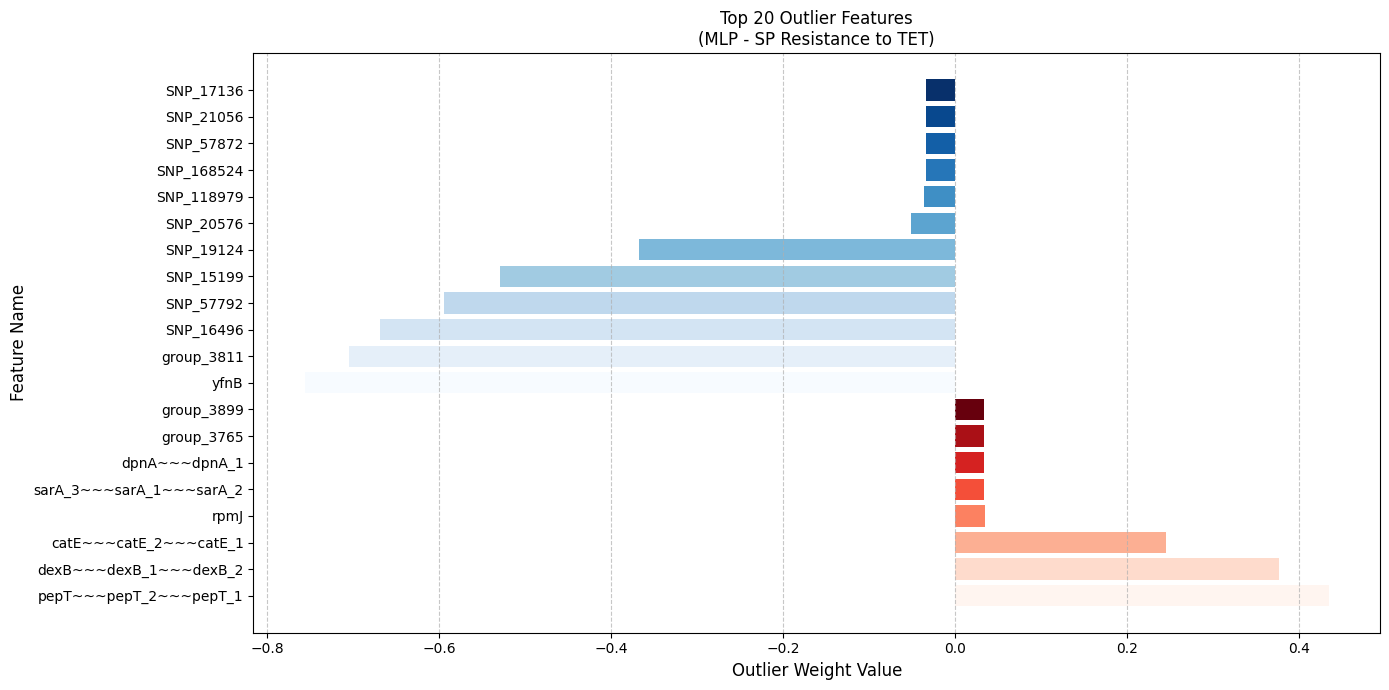

In [25]:
feature_names_tet, outlier_weights_tet = get_top_outliers(mlp_tet, X_train_tet)
visualize_outliers(feature_names_tet, outlier_weights_tet, drug_name="TET")

##### 3. AZM

Outlier indices based on Z-scores: [  18311   19081   19089 ... 1843337 1843338 1843339]
Top 20 outlier indices: [1843333 1843339 1843334 1843338 1843337 1843336 1843332 1843330 1843335
 1843331 1325825 1325655  832585 1522131 1522061  695095  931721  727342
 1643801 1522091]
Top 20 outlier features (input feature indices): [     3      9      4      8      7      6      2      0      5      1
  35494  35324  95253  47467  47397 142096  10056 174343 169137  47427]
Top 20 Outlier Features and Their Corresponding Weights:
Feature 3: Weight = -0.7650274038314819
Feature 9: Weight = -0.7143421769142151
Feature 4: Weight = -0.6787806749343872
Feature 8: Weight = -0.6035245060920715
Feature 7: Weight = -0.5368845462799072
Feature 6: Weight = 0.4451049268245697
Feature 2: Weight = 0.38729050755500793
Feature 0: Weight = -0.37941575050354004
Feature 5: Weight = 0.25546586513519287
Feature 1: Weight = -0.06171022355556488
Feature 35494: Weight = -0.035809218883514404
Feature 35324: Weight = -0.

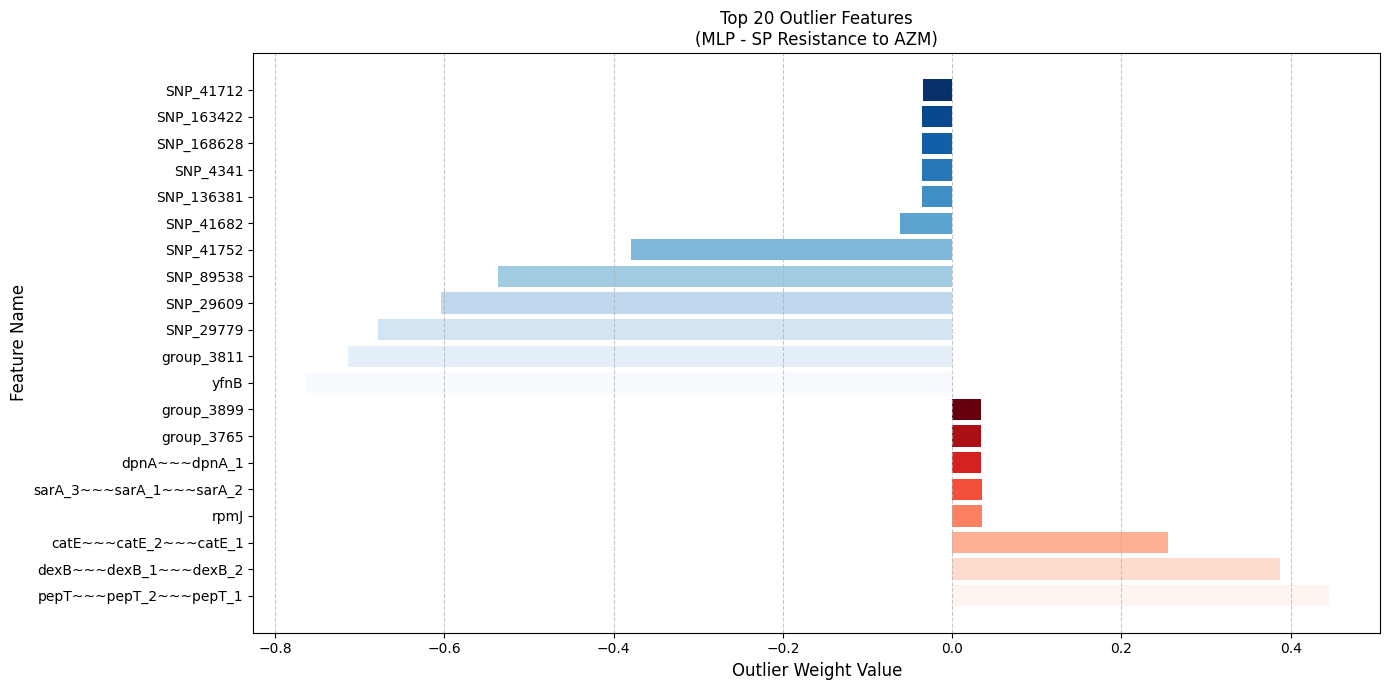

In [26]:
feature_names_azm, outlier_weights_azm = get_top_outliers(mlp_azm, X_train_resampled_azm)
visualize_outliers(feature_names_azm, outlier_weights_azm, drug_name="AZM")